### The objective of this script is to generate the sequence of noise kicks, that are used for the simulations with Sixtracklib and PyHEADTAIL, such as they correspond to a measured spectrum.

**Methodology**
1) Load the measure spectrum, power spectral density in (dBc/Hz)

2) Convert the power spectral density in rad^2/Hz

3) Inverse Fourier transform of the square root of the noise power. Follow the procedure in PSD_to_NoiseSignal.ipynb

4) "Sanity check": Compute and plot the PSD of the resulted signal. 

In [4]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

In [5]:
params = {'legend.fontsize': 16,
          'axes.labelsize': 17,
          'xtick.labelsize': 17,
          'ytick.labelsize': 17}

plt.rc('text', usetex=False)
plt.rcParams.update(params)

In [6]:
def create_noise(N, colored=False):        
    if colored: # A.Wolski's method
        phi_0 = 1e-8  # amplitude of noise, aka stdPhaseNoise 
        Delta_psi = 0.18 # the peak of the spectrum

        psi_t_list = []
        psi_t = 0

        # parameters for ksi
        mean = 0.0
        std = 0.06
        for i in range(N):
            psi_t_list.append(psi_t)
            ksi = np.random.normal(mean, std)  # different seed on each turn
            psi_t = psi_t + 2 * np.pi * Delta_psi + 2 * np.pi * ksi

        # Construct the noise signal
        y = phi_0 * np.cos(psi_t_list)
        
    else:
        mu, stdPhaseNoise = 0, 1e-8
        y = np.random.normal(mu, stdPhaseNoise, N)
    
    return y

In [81]:
def compute_PSD(N, frev, noise_flag):
    time = np.arange(N)/frev # convert from turns to time
    Dt = time[1]-time[0] # sampling (s)
    freq = np.linspace(0, N/time[-1], N)
    Df = freq[1]-freq[0]
   
    #### To obtain a more precise value of PSD, we use the average of 10000 FFTs
    fft_list = []
    for i in range(1000):
        y_noise = create_noise(N, noise_flag)
        fft = np.fft.fft(y_noise)
        fft_list.append(fft)
        
    mean_dft = np.mean(np.abs(fft_list)**2, axis=0)
    PSD = mean_dft/(Df*N**2) # power spectral density
    
    # compute the PSD at the frequency of interest. 
    # In our case in the betatron frequency, vb. 
    # find the closest value to the vb at the frequency list
    vb = 0.18
    closest_to_vb = freq[min(range(len(freq)), key=lambda i: abs(freq[i] - vb*frev))] # Hz
    PSD_vb_index = [i for i in range(len(freq)) if freq[i] == closest_to_vb]
    PSD_vb = PSD[PSD_vb_index] # rad^2/Hz or V^2/Hz
    
    
    return PSD, freq, PSD_vb

In [82]:
N = int(1e3) # length of the signal
frev = 43.45e3 # the revolution frequency of SPS
noise_flag = False # False for white noise, True for colroed noise

In [83]:
PSD, freq, PSD_vb = compute_PSD(N, frev, noise_flag)

1000


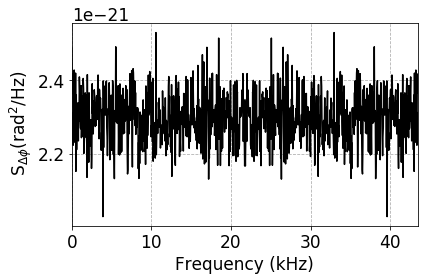

In [10]:
plt.plot(np.array(freq)/1000, PSD, c ='k')
plt.xlabel('Frequency (kHz)', fontsize=17)
plt.ylabel(' S'+ r'$_{\Delta \phi}$'+ '(rad'+r'$^2$'+'/Hz)', fontsize=17)
plt.grid(linestyle='--')
#plt.ylim(1e-21, 4e-21)
plt.xlim(0, 43.45)
plt.tight_layout()
#plt.savefig('PSD_rmsksi6e-2.png')

# From the PSD compute the noise kicks, with the square root of the psd

#### Linear interpolation

The measured data are equally spaced in logarithmic scale. We need to do a linear interpolation on the poewer spectral density to the wanted frequency array. 

- Sampling: dt = 1 (sequence of noise kicks applied every turn)
- Sampling frequency: 1/dt
- Length of signal: N, equals the turns of the simulations

In [78]:
N = 1e5/2
time = np.arange(N)/frev # convert from turns to time
Dt = time[1]-time[0] # sampling (s)
freq = np.linspace(0, N/time[-1], N)
Df = freq[1]-freq[0]

In [79]:
PSD_list_new = np.ones(int(N))*np.mean(PSD)

In [68]:
# Convert the noise power to fft amplitude, A(f(k))
A = np.sqrt(PSD_list_new*Df*(N**2))
A[0] = 0 # set the 0 component to 0
# Close to zero amplitude for frequencies lower than 1kHz and higher than the revolution frequency set
A[freq > 43.45e3] = np.sqrt(1e-22*Df*N**2)  
A[freq < 1e3] = np.sqrt(1e-22*Df*N**2) # optional

In [69]:
#Give each spectral component a random phase, uniformly distributed between 0 and the frange, Phi(f(k))
phi = np.exp(1j*2*np.pi*np.random.uniform(0,1,len(freq)))

In [70]:
# Construct the FFT signal 
phaseerrorsfft = A*phi

In [71]:
# complex conjugate of all but the first element
phaseerrorsfft_conj = np.conj(phaseerrorsfft[1:])
# Reverse the list
reversed_list = phaseerrorsfft_conj[::-1]
# merge them
merged_list = list(phaseerrorsfft) + list(reversed_list)
merged_list[0] = 0

In [72]:
phaseerrors = np.real(np.fft.ifft(merged_list))

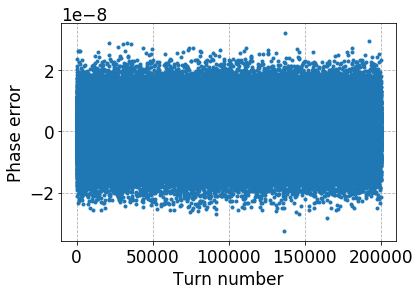

In [73]:
plt.plot(phaseerrors, '.')
plt.xlabel('Turn number')
plt.ylabel('Phase error')
plt.grid(True, linestyle='--')

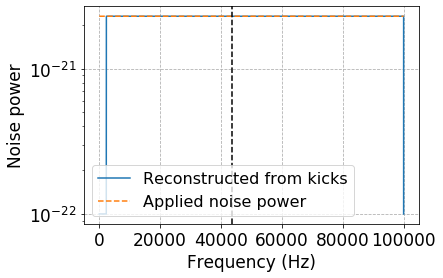

In [77]:
#Reconstruct the noise power spectrum from the phase errors
phaseerrorsfft1 = np.fft.fft(phaseerrors)
plt.plot(np.abs(phaseerrorsfft1[1:len(freq)])**2/(Df*N**2), label='Reconstructed from kicks')
plt.plot(PSD_list_new, label='Applied noise power', linestyle='--')
plt.legend(loc=3)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Noise power')
plt.grid(True, linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.axvline(43.45e3, c='k', linestyle='dashed', label='revlution frequency, 43.45 kHz')

In [75]:
np.std(phaseerrors)

6.984885534233082e-09

In [80]:
np.std(phaseerrors)*(270e9/1e6)

0.0018859190942429323

In [63]:
np.mean(phaseerrors) # almost zero

-4.1028568668316854e-27